# Анализ решений по апелляциям на постановления ГИБДД
## п.5 Classification model

Цель данного этапа - построение модели классификации: 
- Ввод известных данных по делу (признаков): дата, статья, факторы, суд, наличие представителя и пр. 
- На выходе: вероятность каждого принятие целевой переменной (result) принятие каждого из 4-х возможных значений

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv
import datetime as dt
from matplotlib import pyplot as plt

## 1. Load data

In [2]:
#load from csv
df_gibdd = pd.read_csv('df_gibdd.csv')
df_gibdd.head()

,region,court,judge,vidpr,etapd,category,result,date,vid_dokumenta,file,...,video,DTP,registrator,svidetel,ponyatoy,passazhir,peshekhod,poterpevshiy,judgments_type,judgment_termination
0,Москва,Басманный районный суд (Город Москва),Карпов Артур Геннадьевич,Административное,Апелляция,12.16 ч.1,Оставлено без изменения,06.11.2012,решение,../../data/sou/basmannyj-rajonnyj-sud-gorod-mo...,...,видео,True,False,True,False,False,False,False,Постановление по делу об АП,False
1,Москва,Басманный районный суд (Город Москва),Дударь Н. Н.,Административное,Апелляция,12.14 ч.3,Оставлено без изменения,05.07.2012,решение,../../data/sou/basmannyj-rajonnyj-sud-gorod-mo...,...,Нет,True,False,False,False,False,False,False,Постановление по делу об АП,False
2,Москва,Басманный районный суд (Город Москва),Дударь Н. Н.,Административное,Апелляция,12.14 ч.3,Оставлено без изменения,05.07.2012,решение,../../data/sou/basmannyj-rajonnyj-sud-gorod-mo...,...,Нет,True,False,True,False,True,False,False,Постановление по делу об АП,False
3,Москва,Басманный районный суд (Город Москва),Дударь Наталия Николаевна,Административное,Апелляция,12.14 ч.3,Оставлено без изменения,13.09.2012,решение,../../data/sou/basmannyj-rajonnyj-sud-gorod-mo...,...,Нет,True,False,False,False,False,False,False,Постановление по делу об АП,False
4,Москва,Басманный районный суд (Город Москва),Скуридина Ирина Анатольевна,Административное,Апелляция,12.16 ч.5,Оставлено без изменения,07.03.2013,решение,../../data/sou/basmannyj-rajonnyj-sud-gorod-mo...,...,Нет,False,False,False,False,False,False,False,Постановление по делу об АП,False


## 2. Preprocessing of data

In [3]:
#add year and month columns
df_gibdd['date'] = pd.to_datetime(df_gibdd['date'])
df_gibdd['year'] = df_gibdd['date'].dt.year
df_gibdd['month'] = df_gibdd['date'].dt.month
#del uninformative features and target
train_data = df_gibdd.drop(['region', 'judge', 'vidpr', 'etapd', 'vid_dokumenta', 
                            'file', 'first_instance', 'result', 'date'], axis=1)
cat_features = list(train_data.columns) #all features are categorical
train_labels = df_gibdd[['result']]

## 3. Model checking on cross-validation

In [4]:
#create train dataset
train_dataset = Pool(data=train_data,
                     label=train_labels,
                     cat_features=cat_features)
#CatBoostClassifier params
params = {'iterations':500,
          'learning_rate':0.05,
          'depth':6,
          'loss_function':'MultiClassOneVsAll',
          'custom_metric':['TotalF1', 'F1'],
          'random_seed':1}

model = CatBoostClassifier(iterations=500,
                           learning_rate=0.05,
                           depth=6,
                           loss_function='MultiClassOneVsAll',
                           custom_metric=['TotalF1', 'F1'],
                           random_seed=1,)
model.fit(train_dataset, silent=True)

In [5]:
print('Model classes: \n{}'.format(model.classes_))

Model classes: 
['Изменено', 'Оставлено без изменения', 'Отменено возвращением на новое рассмотрение', 'Отменено с прекращением производства']


In [6]:
#CatBoostClassifier params for cv
params = {'iterations':500,
          'learning_rate':0.05,
          'depth':6,
          'loss_function':'MultiClassOneVsAll',
          'custom_metric':['TotalF1', 'F1'],
          'random_seed':1}

#cross-validation
scores = cv(train_dataset,
            params,
            fold_count=3,
            stratified = True,
            partition_random_seed=1,
            logging_level = 'Silent',
            plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [7]:
def add_classes_names(df, classes_names=model.classes_):
    columns = ['F1: '+s for s in model.classes_]
    columns = [i+' ('+j+')' for i, j in zip(df.columns[:4], model.classes_)]
    columns.extend(df.columns[4:])
    return columns

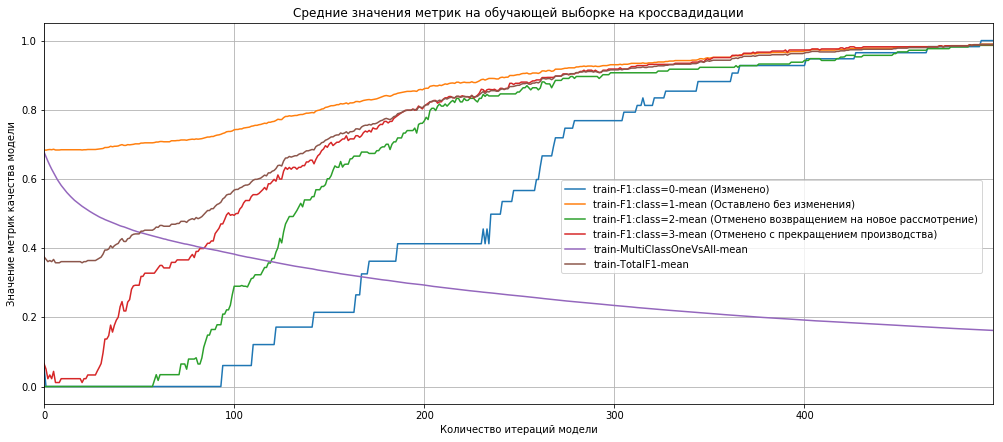

In [8]:
scores_columns = [scores.columns[2*i-1] for i in range(1, int((len(scores.columns)+1)/2))]
scores_train = scores[scores_columns[6:]]
scores_train.columns = add_classes_names(scores_train)
scores_train.plot(figsize=(17,7),  grid=True,
         title='Средние значения метрик на обучающей выборке на кроссвадидации').legend(bbox_to_anchor=(0.54, 0.6))
plt.xlabel('Количество итераций модели')
plt.ylabel('Значение метрик качества модели')
plt.show()

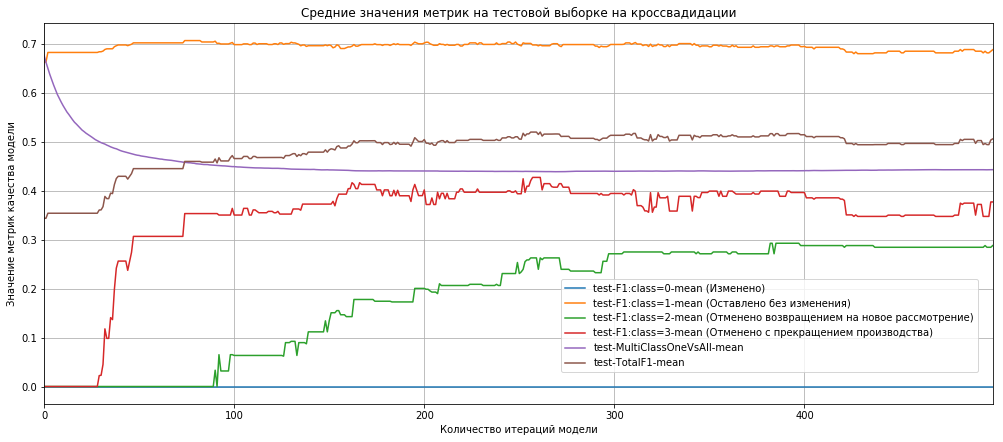

In [9]:
scores_columns = [scores.columns[2*i-1] for i in range(1, int((len(scores.columns)+1)/2))]
scores_test = scores[scores_columns[:6]]
scores_test.columns = add_classes_names(scores_test)
scores_test.plot(figsize=(17,7), grid=True,
                 title='Средние значения метрик на тестовой выборке на кроссвадидации').legend(bbox_to_anchor=(0.54, 0.07))
plt.xlabel('Количество итераций модели')
plt.ylabel('Значение метрик качества модели')
plt.show()

Предварительные выводы 19.11.2019:

1. На 3-х фолдовой кросс-валидации на тестовой выборке достигнутые оптимальные значения метрик MultiClassOneVsAll (0.44 на 263-й итерации) и TotalF1 (0.52 на 257-й итерации) получились не сильно отличающимися от 0.5, что говорит о достаточно низком качестве модели многоклассовой классификации.
2. Однако среднее значение метрики F1 для класса = 1 (Оставленно без изменения) - уже на 74-й итерации достигла своего максимума (0,7), что является относительно неплохим качеством в случае задачи бинарной классификации класс = 1 против всех остальных классов. 
3. В первую очередь низкое качество модели многоклассовой классификции обусловлено довольно маленьким размером датасета (всего 322 объекта), а также сильным дисбалансом классов (класс 1 (Оставленно без измнения): более 50%, класс 0 (Изменено): < 5%)

Дальнейшее шаги по улучшению модели:
1. В первую очередь требуется получить больше данных (текстов судебных решений), для этого в данный момент ведётся работа по созданию парсера текстов дел, с основных открытых сайтов, где хранятся судебные акты.
2. Провести более тщательный анализ зависимостей различных факторов на целевую переменную, пи необходимости произвести дополнительный отбор признаков, либо дополнительное извлечение или генерацию признаков.
3. После выполнения вышеперечисленных пунктов будет заново построена модель на обновленных данных, произведена её настройка, при необходимости возможно использование других алгоритмов и сравнение их качества. 